# 2022년 3월 단톡방 통계

## 패키지

In [1]:
import datetime as dt
import re

import pandas as pd
import matplotlib.pyplot as plt

### plt 한글 출력

In [2]:
from matplotlib import font_manager, rc

font_path = 'C:/Windows/Fonts/malgun.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## 함수 선언

### 12시간제 -> 24시간제

In [3]:
def ampm_to_2400(time_str:str) :
    am_pm, clock = time_str.split()
    hour, minute = map(int, clock.split(':'))

    if am_pm == '오후' and hour != 12 :
        hour += 12

    if am_pm == '오전' and hour == 12 :
        hour = 0

    return hour, minute

### 메세지 전송 시점의 초 계산
  - 카톡에서 메세지 전송 시점을 분까지만 저장
  - 그대로 사용시 해당 시,분에 전송된 메세지 전체가 0초에 동시에 전송된 것 처럼 보임
  - 전송된 순서 구분을 위해 같은 시,분의 첫 메세지를 0초, 이후 1초씩 증가

In [4]:
def calc_second(ph, pm, ps, nh, nm) :
    if ph == nh and pm == nm :
        ns = ps + 1
    else :
        ns = 0
    
    return ns

### 메세지 파싱
  - 메세지 전송 시점, 보낸 사람, 메세지 내용이 하나로 합쳐진 상태
    + ex) '2022년 3월 1일 오전 12:35, 킹산대 : https://www.youtube.com/watch?v=TliJaoPup4Q'
  - 전송 시점, 보낸 사람, 메세지 내용을 분리

In [5]:
p = re.compile('([\d]+)년 ([\d]+)월 ([\d]+)일 (\w+\s+\d+[:]\d+), ([\w-]+) : ([\s|\S|\d]+)')

def msg_parsing(msg) :
    s = p.match(msg)

    if s == None :
        return s
    else :
        s = s.groups()
        return (int(s[0]), int(s[1]), int(s[2]), s[3], s[4], s[5])

### 메세지 분리
  - 전체 텍스트를 각 메세지 별로 분리
  - split 구분자를 '\n'으로 할 경우 메세지 안에 줄바꿈이 있으면 내용이 분리됨
    + ex) ![Longest](https://github.com/nsms556/GroupTalk/blob/master/img/msg_include_newliine.png?raw=true)
  - 따라서 새로운 구분자를 생성하여 '\n' 문자 대신 사용
  - 이후 메세지 맨끝의 줄바꿈 문자만 제거

In [6]:
def fulltext_to_messages(t) :
    line_sep = '[Line Separator]'
    
    t = t.replace('\n202', f'\n{line_sep}202')

    msgs = t.split(line_sep)
    msgs = list(map(lambda x : x[:-1], msgs))

    return msgs

### 데이터프레임으로 변환

In [157]:
from anonymous import alias

def messages_to_df(msgs, anonymize=True) :
    prev_hour = -1
    prev_minute = -1
    second = 0

    datetimes, names, messages = [], [], []

    for msg in msgs :
        msg_parse = msg_parsing(msg)

        if msg_parse == None :
            continue
        else :
            year, month, day, clock, name, string = msg_parse

            hour, minute = ampm_to_2400(clock)
            second = calc_second(prev_hour, prev_minute, second, hour, minute)

            datetimes.append(pd.Timestamp(year, month, day, hour, minute, second))

            if anonymize :
                names.append(alias[name])
            else :
                names.append(name)
            messages.append(string)

            prev_hour, prev_minute = hour, minute
    
    return pd.DataFrame({'Name':names, 'Message':messages}, index=datetimes)

## 데이터프레임 생성

In [8]:
talk_file = '2022-03.txt'

with open(talk_file, 'r', encoding='UTF-8') as f :
    text = f.read()

In [9]:
msgs = fulltext_to_messages(text)

In [162]:
df = messages_to_df(msgs)
df['MSG_length'] = df['Message'].apply(len)

In [163]:
df

,Name,Message,MSG_length
2022-03-01 00:35:00,킹산대,https://www.youtube.com/watch?v=TliJaoPup4Q,43
2022-03-01 01:04:00,솔개,피켓좌,3
2022-03-01 01:04:01,솔개,못하는게 뭐야,7
2022-03-01 01:23:00,킹산대,https://www.youtube.com/watch?v=pwTgT6d8wAI,43
2022-03-01 01:23:01,킹산대,ㄹㅇㅋㅋ,4
...,...,...,...
2022-03-31 20:07:00,백수,이모티콘,4
2022-03-31 20:23:00,백수,https://www.twitch.tv/beryl0202,31
2022-03-31 20:23:01,백수,베릴 하루종일 방송하네,12
2022-03-31 20:29:00,솔개,사진,2


## 통계

### 인원별 최장 톡 길이

In [164]:
df.groupby('Name')['MSG_length'].max()

Name
백수     183
뱅뱅뱅    331
서방     464
솔개      63
슥사     233
윤계상     37
킹산대     65
Name: MSG_length, dtype: int64

### 인원별 톡 길이 평균
  - 최고의 단문펀치를 찾아라

In [165]:
df.groupby('Name')['MSG_length'].mean()

Name
백수     10.150920
뱅뱅뱅    13.019849
서방     13.965820
솔개     11.006406
슥사      7.015410
윤계상    10.666667
킹산대    11.773741
Name: MSG_length, dtype: float64

### 2022년 3월 가장 긴 톡

In [166]:
longest_msg = df.loc[df['MSG_length'].idxmax()]
print(longest_msg)
print(longest_msg['Message'])

Name                                                         서방
Message       ⠻⣦⡈⠛⢿⡌⢆⢂⠹⣿⣧⡄⡄⠹⡄⢆⡟⢄⠉⢟⣮⣷⢄⠐⢤⡤⢤⣬⣭⣭\n⣷⣤⠙⣶⣦⠙⡌⢻⠂⠘⣿⣷⢹⠄...
MSG_length                                                  464
Name: 2022-03-08 23:06:00, dtype: object
⠻⣦⡈⠛⢿⡌⢆⢂⠹⣿⣧⡄⡄⠹⡄⢆⡟⢄⠉⢟⣮⣷⢄⠐⢤⡤⢤⣬⣭⣭
⣷⣤⠙⣶⣦⠙⡌⢻⠂⠘⣿⣷⢹⠄⢳⠘⣿⡟⣿⡄⢳⡆⢳⠛⢢⠈⠉⠛⠛⠛
⢿⣿⣷⣀⠈⠓⠌⠂⠘⢆⠈⢙⣎⢣⠘⡆⢣⡛⣿⡇⢀⡙⠚⠶⠶⠿⠷⠶⠒⠒
⣾⠿⣿⣿⣦⣄⣁⣀⣠⡀⠡⠄⠳⡛⢆⠱⠈⢧⣿⡇⠸⠟⠉⠐⠠⠄⠄⠄⣼⣿
⣿⣷⣬⣉⣛⣛⠛⠿⠿⣧⣷⣦⣄⠘⢿⡆⠡⠘⣀⡇⢠⣶⣷⣮⣤⣤⣴⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡀⢿⡀⠄⠉⡇⢸⣿⣿⣿⣉⣉⣉⣉⣉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⣿⣦⡙⠄⠄⠁⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⡙⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⠁⣿⣿⣷⣌⠄⠄⠘⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣦⣀⡨⣝⡻⠿⣻⣿⣧⣄⠄⠄⣿⣿⣿⣿⣿⣦⡀⢻⣿⣿⣿⣿⣿⡿⠿⣿
⣿⣿⣿⣿⡇⢿⡛⢿⣿⣿⣿⣿⣧⠘⣿⣛⣻⣿⣿⣿⣿⣤⡿⢿⠿⣛⡃⠄⣸⣿
⡹⣿⣿⣿⣿⣼⣷⣶⣝⢿⣿⣿⣿⣧⣿⣿⣿⣿⣿⣿⣿⣿⡿⠟⣿⢇⣈⣼⣿⣿
⣿⣜⢿⣭⢻⣿⣿⣿⣯⢧⠙⢻⠛⣛⣛⠛⠛⠿⠿⠟⣛⣥⣶⣼⢏⣾⣿⣿⣿⣿
⣿⣿⣎⠿⣇⢻⣿⣿⣿⡌⢷⣆⢭⣓⣒⣒⣛⣣⣶⠞⣵⣿⣿⣿⡿⣱⣾⡟⣵⣿
⣿⣿⣿⣤⣻⡘⣿⣿⣿⣷⡜⢻⣮⣛⣛⣟⣫⡿⣛⣴⣿⣿⣿⣿⢃⣿⣿⣷⣿⣿
⣿⣿⣿⣿⣷⣣⢹⣿⣿⣿⣿⣯⡙⠛⠛⠛⢛⣺⣿⣿⣿⣿⣿⠇⣼⢫⣵⣿⣿⣿


### 톡 개수 기준 단톡방 지분율

In [167]:
msg_share_by_count = df.groupby('Name').count()['Message'] / len(df) * 100
msg_share_by_count

Name
백수     20.380095
뱅뱅뱅    17.637743
서방      8.535467
솔개     13.011586
슥사     30.290906
윤계상     0.050013
킹산대    10.094190
Name: Message, dtype: float64

#### 그래프

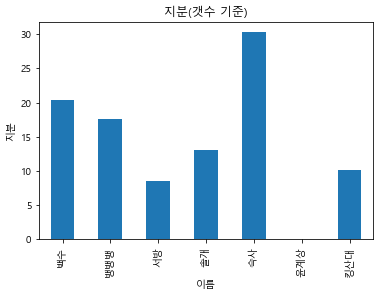

In [180]:
msg_share_by_count.plot(kind='bar')

plt.title('지분(갯수 기준)')

plt.xlabel('이름')
plt.ylabel('지분')

plt.savefig('img/share_by_count.png', edgecolor='black', facecolor='#eeeeee', bbox_inches='tight')
plt.show()

### 톡 길이 기준 단톡방 지분율
  - 최고의 장문충을 찾아라


In [169]:
msg_share_by_length = df.groupby('Name')['MSG_length'].sum() / df['MSG_length'].sum() * 100
msg_share_by_length

Name
백수     20.069218
뱅뱅뱅    22.277568
서방     11.564120
솔개     13.892954
슥사     20.615039
윤계상     0.051752
킹산대    11.529349
Name: MSG_length, dtype: float64

#### 그래프


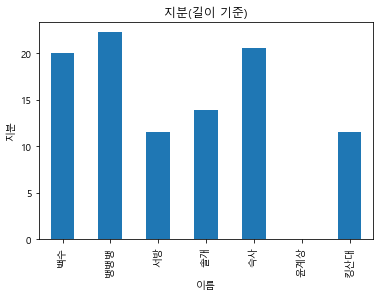

In [181]:
msg_share_by_length.plot(kind='bar')

plt.title('지분(길이 기준)')

plt.xlabel('이름')
plt.ylabel('지분')

plt.savefig('img/share_by_length.png', edgecolor='black', facecolor='#eeeeee', bbox_inches='tight')
plt.show()

### 일별 메세지 전송 개수

In [171]:
daily_msg = df.groupby('Name').resample('D')['Message'].count().unstack().T.fillna(0).astype(int)
daily_msg.index = daily_msg.index.date
daily_msg

Name,백수,뱅뱅뱅,서방,솔개,슥사,윤계상,킹산대
2022-03-01,56,100,21,20,31,0,32
2022-03-02,87,160,1,132,191,0,50
2022-03-03,166,191,1,175,458,0,122
2022-03-04,142,375,180,252,515,0,204
2022-03-05,128,144,12,6,76,0,26
2022-03-06,103,150,22,23,138,0,0
2022-03-07,92,171,70,89,316,0,13
2022-03-08,187,496,97,232,515,0,55
2022-03-09,319,307,8,82,295,0,39
2022-03-10,48,17,35,10,20,0,39


#### 그래프

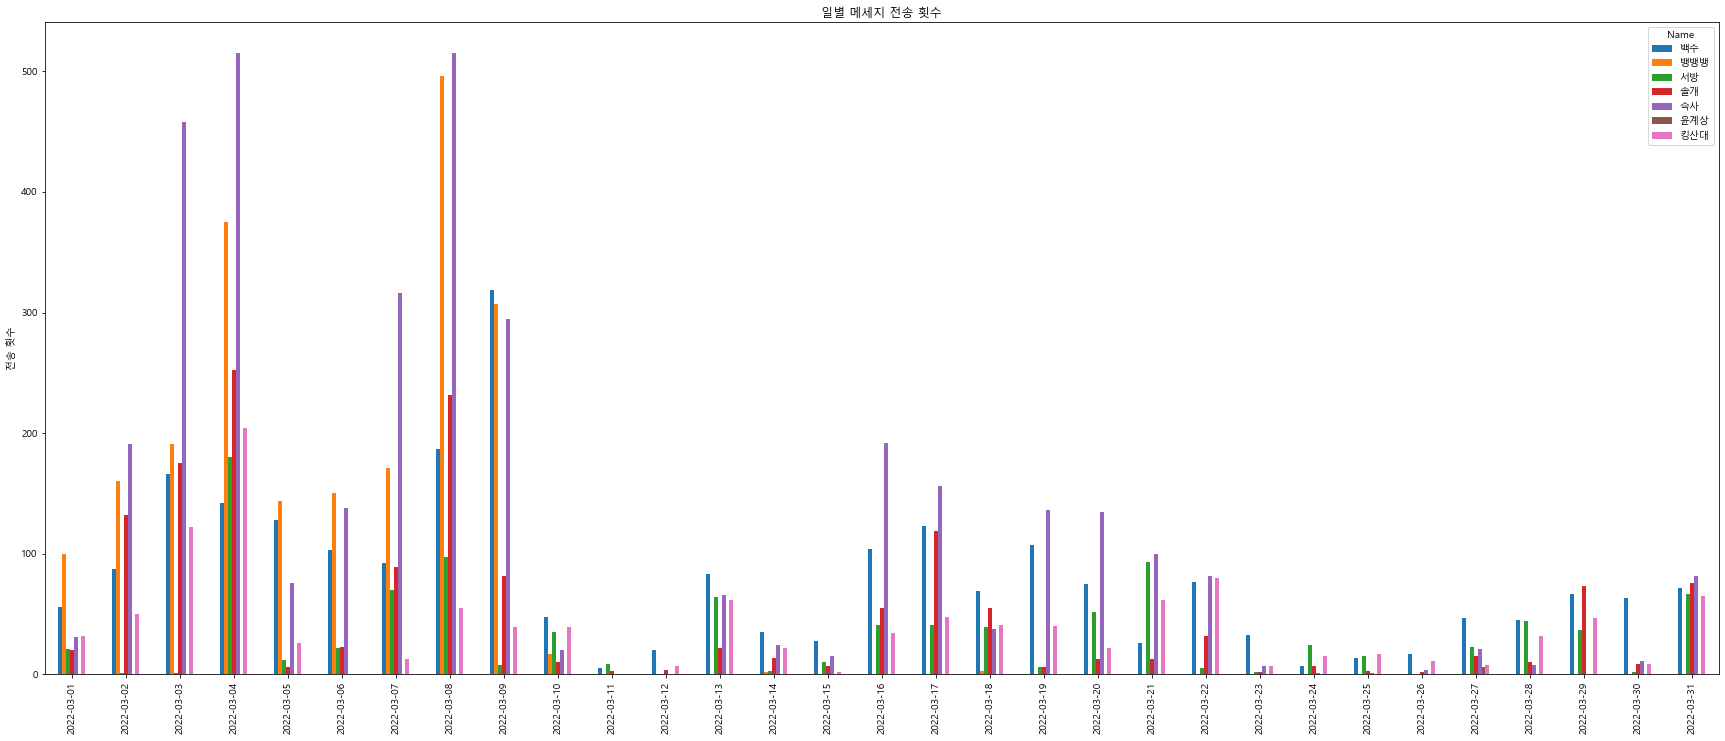

In [182]:
daily_msg.plot(figsize=(30, 12), kind='bar')

plt.title('일별 메세지 전송 개수')

plt.ylabel('전송 개수')

plt.savefig('img/Daily_count.png', edgecolor='black', facecolor='#eeeeee', bbox_inches='tight')

plt.show()

### 일별 전송한 메세지 총 길이

In [173]:
daily_msg_length = df.groupby('Name').resample('D')['MSG_length'].sum().unstack().T.fillna(0).astype(int)
daily_msg_length.index = daily_msg_length.index.date
daily_msg_length

Name,백수,뱅뱅뱅,서방,솔개,슥사,윤계상,킹산대
2022-03-01,645,1132,318,196,181,0,367
2022-03-02,820,2589,9,1399,1351,0,635
2022-03-03,1642,2946,2,2037,3191,0,1601
2022-03-04,1574,4831,2260,2857,3470,0,2152
2022-03-05,1707,2098,73,108,613,0,297
2022-03-06,966,2082,332,375,1211,0,0
2022-03-07,894,2537,1131,936,2525,0,134
2022-03-08,1670,5538,1644,2514,3266,0,507
2022-03-09,2793,3602,55,643,1849,0,391
2022-03-10,523,170,467,133,90,0,533


#### 그래프

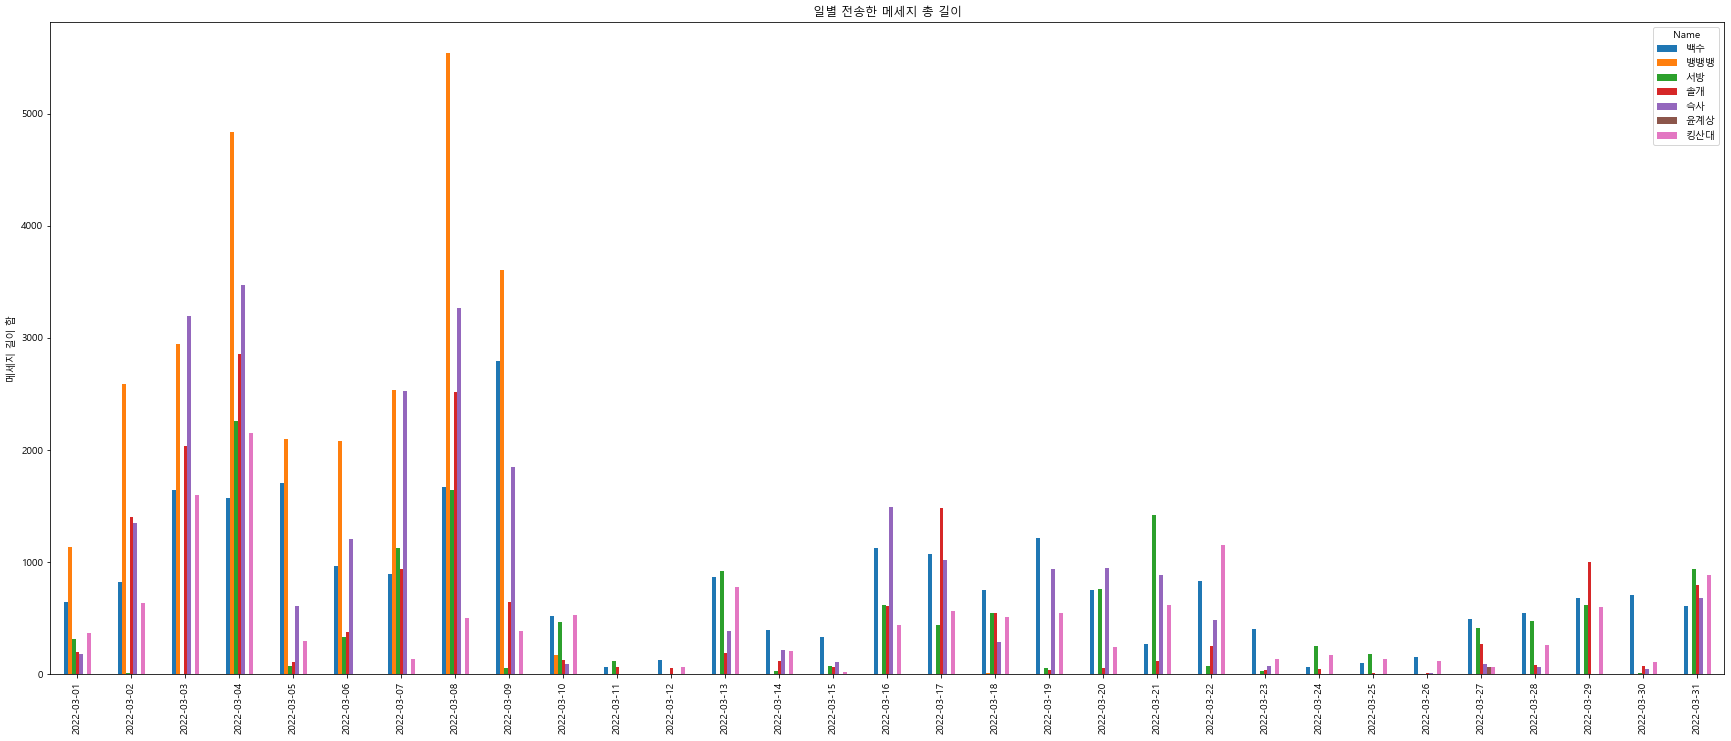

In [183]:
daily_msg_length.plot(figsize=(30, 12), kind='bar')

plt.title('일별 전송한 메세지 총 길이')

plt.ylabel('메세지 길이 합')

plt.savefig('img/Daily_length.png', edgecolor='black', facecolor='#eeeeee', bbox_inches='tight')

plt.show()

### 시간대 분포

In [175]:
hour_msg_total = df.groupby(df.index.hour)['Message'].count().fillna(0).astype(int)
hour_msg_total

0      398
1      187
2       81
3       51
4        6
5        3
6       10
7       36
8       96
9      369
10     385
11     486
12    1291
13     588
14    1043
15     572
16    1100
17    1292
18     835
19     843
20     454
21     670
22     494
23     707
Name: Message, dtype: int32

#### 그래프

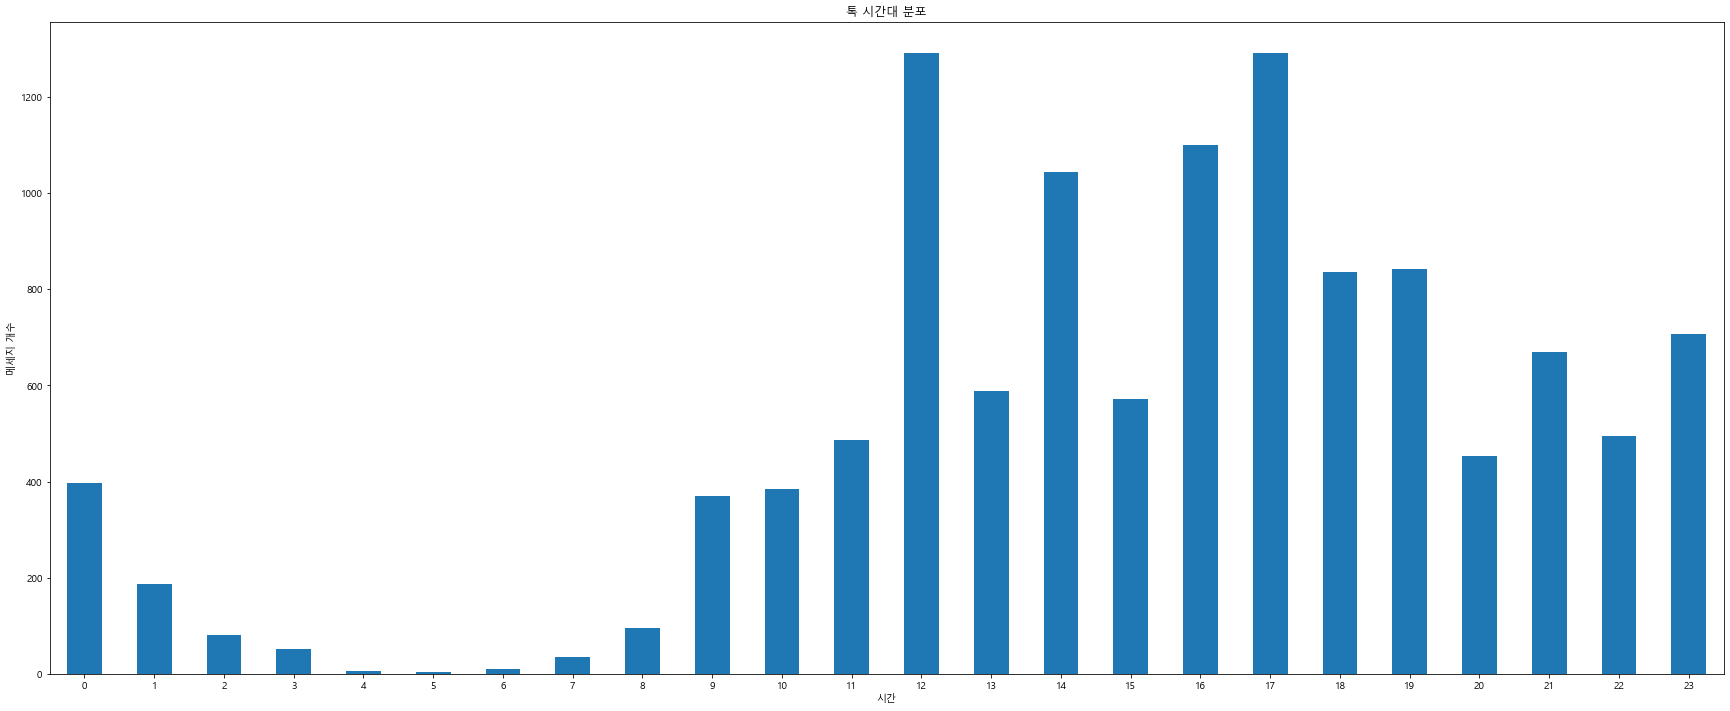

In [185]:
ax = hour_msg_total.plot(figsize=(30, 12), kind='bar')

plt.title('톡 시간대 분포')

plt.xticks(rotation=0)
plt.xlabel('시간')

plt.ylabel('메세지 개수')

plt.savefig('img/Hour_total.png', edgecolor='black', facecolor='#eeeeee', bbox_inches='tight')

plt.show()

#### 새벽 4~5시 누구야
  - 니네 안자니?

In [ ]:
df[(df.index.hour==4) | (df.index.hour==5)]

### 인원별 시간대 분포

In [178]:
hour_msg = df.groupby([df.index.hour, df['Name']])['Message'].count().unstack().fillna(0).astype(int)
hour_msg

Name,백수,뱅뱅뱅,서방,솔개,슥사,윤계상,킹산대
0,102,61,64,19,90,0,62
1,67,8,15,7,53,0,37
2,17,0,23,5,19,0,17
3,4,0,17,15,5,0,10
4,0,0,2,3,0,0,1
5,0,0,1,0,0,0,2
6,0,6,0,2,0,0,2
7,0,18,0,7,9,0,2
8,6,26,2,9,30,0,23
9,33,25,60,60,122,0,69


#### 그래프

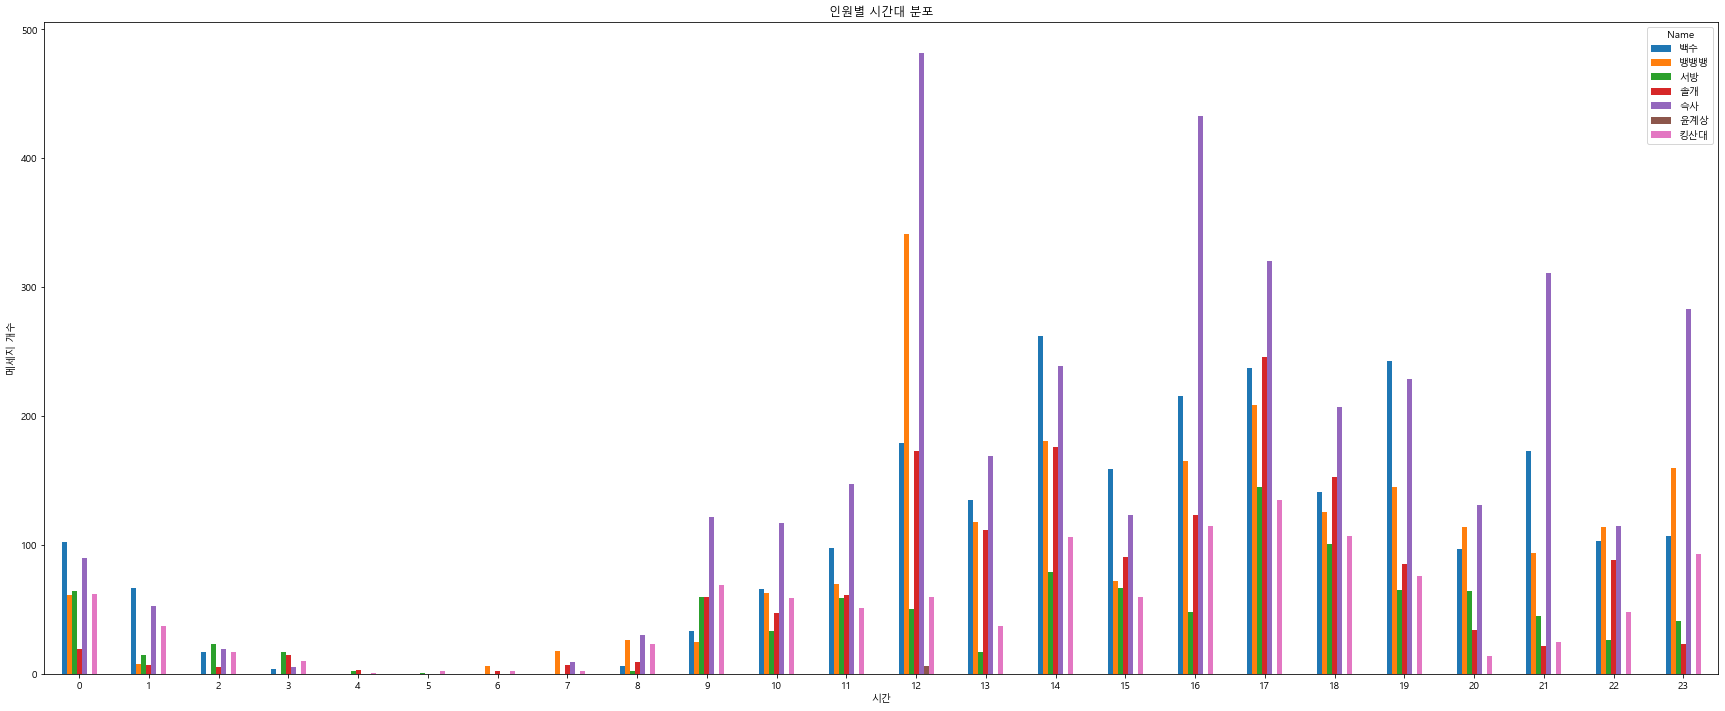

In [186]:
ax = hour_msg.plot(figsize=(30, 12), kind='bar' )

plt.title('인원별 시간대 분포')

plt.xticks(rotation=0)
plt.xlabel('시간')

plt.ylabel('메세지 개수')

plt.savefig('img/Hour_count.png', edgecolor='black', facecolor='#eeeeee', bbox_inches='tight')

plt.show()